C:\Users\OGrex\AppData\Local\Temp\ipykernel_15116\1527976150.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\Users\OGrex\AppData\Local\Temp\ipykernel_15116\1527976150.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


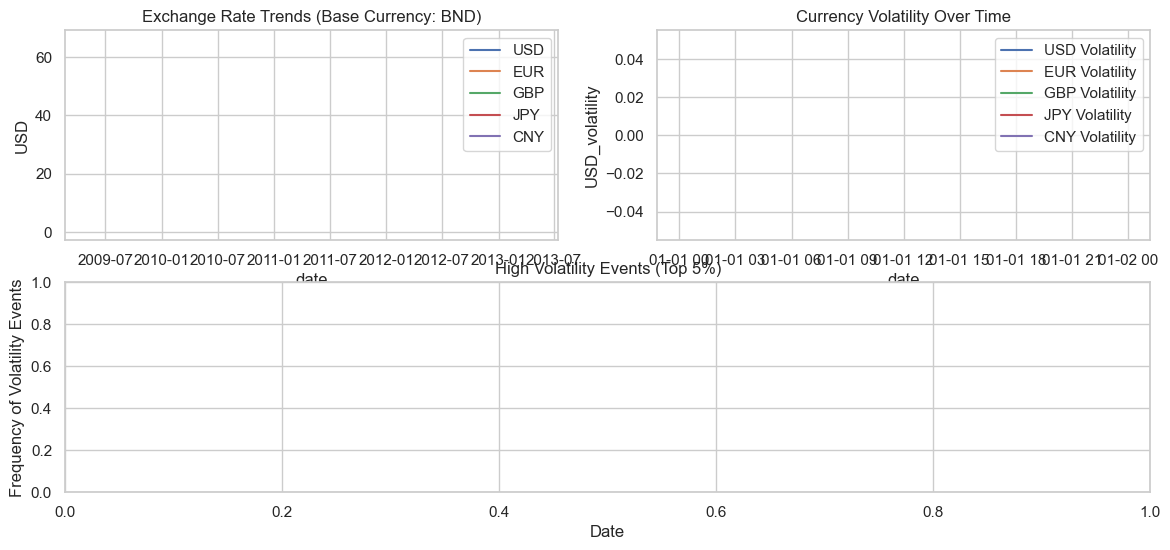

In [33]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

sns.set(style="whitegrid")

currencies = ["USD", "EUR", "GBP", "JPY", "CNY"]

data = []
for filename in os.listdir("."):
    if filename.endswith(".json"):
        date = filename.split("_exchange_rates_")[0] 
        with open(os.path.join(".", filename)) as f:
            json_data = json.load(f)
            base_currency = json_data.get("channel", {}).get("baseCurrency", "")
            rates = {"date": date, "base_currency": base_currency}
            items = json_data.get("channel", {}).get("item", [])

            if isinstance(items, dict): 
                items = [items]

            for item in items:
                target_currency = item.get("targetCurrency")
                if target_currency in currencies:
                    rates[target_currency] = float(item.get("exchangeRate", 1.0))

            if any(c in rates for c in currencies):
                data.append(rates)

df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])

base_currency = df["base_currency"].iloc[0] if "base_currency" in df.columns else "USD"
if base_currency in df.columns:
    for c in currencies:
        if c in df.columns and c != base_currency:
            df[c] = df[c] / df[base_currency]
    df[base_currency] = 1.0

df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

volatility_window = 30
for c in currencies:
    if c in df.columns:
        df[f"{c}_volatility"] = df[c].pct_change().rolling(volatility_window).std() * 100

volatility_threshold = df[[f"{c}_volatility" for c in currencies]].quantile(0.95)
high_volatility_dates = df[df[[f"{c}_volatility" for c in currencies]].gt(volatility_threshold).any(axis=1)]["date"]

plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
for c in currencies:
    if c in df.columns:
        sns.lineplot(x="date", y=c, data=df, label=c)
plt.title(f"Exchange Rate Trends (Base Currency: {base_currency})")
plt.legend()

plt.subplot(2, 2, 2)
for c in currencies:
    if f"{c}_volatility" in df.columns:
        sns.lineplot(x="date", y=f"{c}_volatility", data=df, label=f"{c} Volatility")
plt.title(f"Currency Volatility Over Time")
plt.legend()

plt.subplot(2, 1, 2)
sns.histplot(high_volatility_dates, bins=20, color="red", kde=True)
plt.title("High Volatility Events (Top 5%)")
plt.xlabel("Date")
plt.ylabel("Frequency of Volatility Events")

plt.show()

def get_logger(name: str):
    logger = logging.getLogger(name)
    if not logger.handlers:
        logger.setLevel(logging.INFO)
        ch = logging.StreamHandler()
        ch.setFormatter(logging.Formatter('[%(levelname)s] %(message)s'))
        fh = logging.FileHandler("quest.log")
        fh.setFormatter(logging.Formatter('%(asctime)s [%(levelname)s] %(message)s'))
        logger.addHandler(ch)
        logger.addHandler(fh)
    return logger